In [ ]:
# take images_and_labels

### CONFIG ###
DATA_DIR = "/home/vladimir_albrekht/projects/img_to_spec/large_files/ILSVRC/imagenet-1k/data"
SPLIT = "train"
START_LABEL = 0
END_LABEL = 100

### IMPORTS ###
from pathlib import Path
import pyarrow.parquet as pq
from collections import Counter
import json

### FUNCTIONS ###
def count_labels(data_dir, split, start_label, end_label):
    data_dir = Path(data_dir)
    parquet_files = sorted(data_dir.glob(f"{split}-*.parquet"))
    
    counter = Counter()
    
    for pq_file in parquet_files:
        table = pq.read_table(pq_file, columns=['label'])
        labels = table['label'].to_pylist()
        
        for label in labels:
            if start_label <= label < end_label:
                counter[label] += 1
    
    return counter

def get_class_names(data_dir):
    parquet_file = next(Path(data_dir).glob("train-*.parquet"))
    table = pq.read_table(parquet_file)
    hf_meta = json.loads(table.schema.metadata[b'huggingface'])
    return hf_meta['info']['features']['label']['names']

### MAIN EXECUTION ###
class_names = get_class_names(DATA_DIR)
label_counts = count_labels(DATA_DIR, SPLIT, START_LABEL, END_LABEL)

print(f"Label distribution for labels {START_LABEL}-{END_LABEL-1}:")
print(f"Total labels in range: {len(label_counts)}")
print(f"Total samples: {sum(label_counts.values())}")
print(f"\nPer-label breakdown:")

for label in sorted(label_counts.keys()):
    print(f"Label {label:3d} ({class_names[label][:40]:40s}): {label_counts[label]:5d} samples")

Label distribution for labels 0-99:
Total labels in range: 100
Total samples: 129395

Per-label breakdown:
Label   0 (tench, Tinca tinca                      ):  1300 samples
Label   1 (goldfish, Carassius auratus             ):  1300 samples
Label   2 (great white shark, white shark, man-eate):  1300 samples
Label   3 (tiger shark, Galeocerdo cuvieri         ):  1300 samples
Label   4 (hammerhead, hammerhead shark            ):  1300 samples
Label   5 (electric ray, crampfish, numbfish, torpe):  1300 samples
Label   6 (stingray                                ):  1300 samples
Label   7 (cock                                    ):  1300 samples
Label   8 (hen                                     ):  1300 samples
Label   9 (ostrich, Struthio camelus               ):  1300 samples
Label  10 (brambling, Fringilla montifringilla     ):  1300 samples
Label  11 (goldfinch, Carduelis carduelis          ):  1300 samples
Label  12 (house finch, linnet, Carpodacus mexicanu):  1300 samples
Label  13

In [ ]:
### CONFIG ###
DATA_DIR = "/home/vladimir_albrekht/projects/img_to_spec/large_files/ILSVRC/imagenet-1k/data"
OUTPUT_DIR = "/home/vladimir_albrekht/projects/img_to_spec/large_files/ILSVRC/images_10_class"
SPLIT = "train"
TARGET_LABELS = list(range(10))  # Labels 0-9
IMAGE_SIZE = 512
MAX_PER_CLASS = None  # None = all, or set a number like 100

### IMPORTS ###
from pathlib import Path
import pyarrow.parquet as pq
from PIL import Image
import io
import json
from tqdm import tqdm

### FUNCTIONS ###

def get_class_names(data_dir):
    """Get class names from parquet metadata."""
    parquet_file = next(Path(data_dir).glob("train-*.parquet"))
    table = pq.read_table(parquet_file)
    hf_meta = json.loads(table.schema.metadata[b'huggingface'])
    return hf_meta['info']['features']['label']['names']


def sanitize_filename(name):
    """Make class name safe for filesystem."""
    # Take first part, replace spaces and special chars
    name = name.split(',')[0].strip()
    name = name.replace(' ', '_').replace('-', '_')
    name = ''.join(c for c in name if c.isalnum() or c == '_')
    return name[:30]  # Limit length


def extract_and_save_images(
    data_dir,
    output_dir,
    split,
    target_labels,
    image_size=512,
    max_per_class=None
):
    """
    Extract images from parquet files, resize to image_size×image_size,
    and save organized by class.
    """
    data_dir = Path(data_dir)
    output_dir = Path(output_dir)
    
    # Get class names
    class_names = get_class_names(data_dir)
    
    # Create output directories
    label_to_dirname = {}
    for label in target_labels:
        class_name = sanitize_filename(class_names[label])
        dir_name = f"{label:03d}_{class_name}"
        label_to_dirname[label] = dir_name
        (output_dir / dir_name).mkdir(parents=True, exist_ok=True)
    
    print(f"Output directories created in {output_dir}")
    for label, dirname in label_to_dirname.items():
        print(f"  Label {label}: {dirname}/")
    
    # Track counts per label
    counts = {label: 0 for label in target_labels}
    
    # Find all parquet files
    parquet_files = sorted(data_dir.glob(f"{split}-*.parquet"))
    print(f"\nFound {len(parquet_files)} parquet files")
    
    # Process each parquet file
    for pq_file in tqdm(parquet_files, desc="Processing parquet files"):
        # Read table
        table = pq.read_table(pq_file, columns=['image', 'label'])
        
        # Get data
        images = table['image'].to_pylist()
        labels = table['label'].to_pylist()
        
        for img_data, label in zip(images, labels):
            # Skip if not in target labels
            if label not in target_labels:
                continue
            
            # Skip if we have enough for this class
            if max_per_class and counts[label] >= max_per_class:
                continue
            
            try:
                # Extract image bytes
                if isinstance(img_data, dict) and 'bytes' in img_data:
                    img_bytes = img_data['bytes']
                elif isinstance(img_data, bytes):
                    img_bytes = img_data
                else:
                    print(f"Unknown image format: {type(img_data)}")
                    continue
                
                # Open and resize image
                img = Image.open(io.BytesIO(img_bytes))
                
                # Convert to RGB if necessary
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Resize to square (center crop + resize for better quality)
                # Option 1: Simple resize (might distort)
                # img = img.resize((image_size, image_size), Image.LANCZOS)
                
                # Option 2: Center crop to square, then resize (preserves aspect)
                w, h = img.size
                min_dim = min(w, h)
                left = (w - min_dim) // 2
                top = (h - min_dim) // 2
                img = img.crop((left, top, left + min_dim, top + min_dim))
                img = img.resize((image_size, image_size), Image.LANCZOS)
                
                # Save
                dir_name = label_to_dirname[label]
                filename = f"{counts[label]:05d}.jpg"
                save_path = output_dir / dir_name / filename
                img.save(save_path, 'JPEG', quality=95)
                
                counts[label] += 1
                
            except Exception as e:
                print(f"Error processing image: {e}")
                continue
        
        # Check if we have enough for all classes
        if max_per_class and all(c >= max_per_class for c in counts.values()):
            print("\nReached max_per_class for all labels, stopping early.")
            break
    
    return counts


### MAIN EXECUTION ###
if __name__ == "__main__":
    print("=" * 60)
    print("IMAGENET IMAGE EXTRACTION")
    print("=" * 60)
    
    counts = extract_and_save_images(
        data_dir=DATA_DIR,
        output_dir=OUTPUT_DIR,
        split=SPLIT,
        target_labels=TARGET_LABELS,
        image_size=IMAGE_SIZE,
        max_per_class=MAX_PER_CLASS
    )
    
    print("\n" + "=" * 60)
    print("EXTRACTION COMPLETE")
    print("=" * 60)
    
    total = 0
    for label in sorted(counts.keys()):
        class_names = get_class_names(DATA_DIR)
        print(f"Label {label:3d} ({class_names[label][:30]:30s}): {counts[label]:5d} images")
        total += counts[label]
    
    print(f"\nTotal images extracted: {total}")
    print(f"Output directory: {OUTPUT_DIR}")
# ```

# ---

# ## Структура Результата
# ```
# /home/vladimir_albrekht/projects/img_to_spec/large_files/ILSVRC/images_10_class/
# ├── 000_tench/
# │   ├── 00000.jpg
# │   ├── 00001.jpg
# │   └── ... (1300 images)
# ├── 001_goldfish/
# │   ├── 00000.jpg
# │   └── ...
# ├── 002_great_white_shark/
# │   └── ...
# ├── 003_tiger_shark/
# │   └── ...
# ├── 004_hammerhead/
# │   └── ...
# ├── 005_electric_ray/
# │   └── ...
# ├── 006_stingray/
# │   └── ...
# ├── 007_cock/
# │   └── ...
# ├── 008_hen/
# │   └── ...
# └── 009_ostrich/
#     └── ...

## PIPER

In [1]:
# 1. download
from huggingface_hub import snapshot_download
from huggingface_hub import login
import dotenv
import os
from pathlib import Path
dotenv.load_dotenv()
login(token=os.getenv("HF_TOKEN"))


repo_id = "rhasspy/piper-voices"
local_dir = Path("piper_tts").resolve()

def download_model_repo(repo_id, local_dir):
    print(f"Downloading repository {repo_id}...")
    snapshot_download(
        repo_id=repo_id,
        allow_patterns=["en/en_US/*"],
        local_dir=str(local_dir)
    )
    print(f"Repository downloaded to {local_dir}")

download_model_repo(repo_id, local_dir)

# # 2. generate speech
# import wave
# from piper import PiperVoice

# # Simple CPU TTS inference

# voice_path = "piper_tts/en/en_US/amy/medium/en_US-amy-medium.onnx"
# text = "Сәлеметсіз бе, бұл мысал сөйлем."
# output_wav = "audio.wav"

# voice = PiperVoice.load(voice_path, use_cuda=False)

# with wave.open(output_wav, "wb") as wav_file:
#     voice.synthesize_wav(text, wav_file)

# print("Done:", output_wav)


Fetching ... files: 0it [00:00, ?it/s]

Repository downloaded to /scratch/vladimir_albrekht/projects/i2m/to_revise/piper_tts


In [1]:
import wave
import json
import random
from pathlib import Path
from piper import PiperVoice
import soundfile as sf
import numpy as np
from tqdm import tqdm
import tempfile

### CONFIG ###
PIPER_DIR = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/piper_tts/en/en_US")
OUTPUT_DIR = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_augmented_v2")
IMAGES_DIR = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/images_10_class")

TARGET_SR = 24000
TARGET_DURATION = 3.0
TARGET_SAMPLES = int(TARGET_SR * TARGET_DURATION)
RANDOM_SEED = 42

CLASS_INFO = {
    "000_tench": "A tench, a freshwater fish",
    "001_goldfish": "A goldfish, bright orange fish",
    "002_great_white_shark": "A great white shark, ocean predator",
    "003_tiger_shark": "A tiger shark with dark stripes",
    "004_hammerhead": "A hammerhead shark with unique head",
    "005_electric_ray": "An electric ray with electric shocks",
    "006_stingray": "A stingray gliding through water",
    "007_cock": "A rooster with colorful feathers",
    "008_hen": "A hen pecking at seeds",
    "009_ostrich": "An ostrich, the largest bird",
}

# ============================================================
# AUGMENTATION FUNCTIONS (only speed and pitch)
# ============================================================

def speed_change(audio, rate, target_length):
    """
    Change speed: rate < 1 = slower (stretched), rate > 1 = faster (compressed)
    Range: 0.75 to 1.35
    """
    indices = np.round(np.arange(0, len(audio), rate)).astype(int)
    indices = indices[indices < len(audio)]
    result = audio[indices]
    
    if len(result) < target_length:
        result = np.concatenate([result, np.zeros(target_length - len(result))])
    else:
        result = result[:target_length]
    return result

def pitch_shift(audio, semitones, target_length):
    """
    Pitch shift by resampling.
    Range: -4 to +4 semitones
    """
    rate = 2 ** (semitones / 12)
    new_length = int(len(audio) / rate)
    indices = np.linspace(0, len(audio) - 1, new_length)
    result = np.interp(indices, np.arange(len(audio)), audio)
    
    if len(result) < target_length:
        result = np.concatenate([result, np.zeros(target_length - len(result))])
    else:
        result = result[:target_length]
    return result

def normalize(audio, max_val=0.95):
    """Normalize to prevent clipping."""
    peak = np.max(np.abs(audio))
    if peak > 0:
        return audio / peak * max_val
    return audio

# ============================================================
# AUGMENTATION CONFIG GENERATOR
# ============================================================

def get_random_augmentation(rng):
    """
    Get random augmentation config.
    Only: speed, pitch, and speed+pitch combination.
    """
    aug_type = rng.choice([
        'none',          # 10% - original
        'speed',         # 30% - speed only
        'pitch',         # 30% - pitch only  
        'speed_pitch',   # 30% - speed + pitch
    ], p=[0.10, 0.30, 0.30, 0.30])
    
    config = {'type': aug_type}
    
    # Speed: 0.75 to 1.35
    speed_values = [0.75, 0.80, 0.85, 0.88, 0.90, 0.92, 0.95, 
                    1.05, 1.08, 1.10, 1.12, 1.15, 1.20, 1.25, 1.30, 1.35]
    
    # Pitch: -4 to +4 semitones
    pitch_values = [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5,
                    0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    
    if aug_type == 'none':
        pass
    
    elif aug_type == 'speed':
        config['speed'] = float(rng.choice(speed_values))
    
    elif aug_type == 'pitch':
        config['pitch'] = float(rng.choice(pitch_values))
    
    elif aug_type == 'speed_pitch':
        config['speed'] = float(rng.choice(speed_values))
        config['pitch'] = float(rng.choice(pitch_values))
    
    return config

def apply_augmentation(audio, config, target_length):
    """Apply augmentation based on config."""
    result = audio.copy()
    
    if 'speed' in config:
        result = speed_change(result, config['speed'], target_length)
    
    if 'pitch' in config:
        result = pitch_shift(result, config['pitch'], target_length)
    
    # Ensure correct length
    if len(result) != target_length:
        if len(result) < target_length:
            result = np.concatenate([result, np.zeros(target_length - len(result))])
        else:
            result = result[:target_length]
    
    return normalize(result)

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def find_all_voices():
    """Find all voices, prefer medium quality."""
    voices_by_speaker = {}
    
    for onnx_file in PIPER_DIR.rglob("*.onnx"):
        parts = onnx_file.relative_to(PIPER_DIR).parts
        if len(parts) >= 3:
            speaker = parts[0]
            quality = parts[1]
            quality_rank = {"medium": 2, "high": 1, "low": 0}
            
            if speaker not in voices_by_speaker:
                voices_by_speaker[speaker] = (onnx_file, quality_rank.get(quality, 0))
            else:
                if quality_rank.get(quality, 0) > voices_by_speaker[speaker][1]:
                    voices_by_speaker[speaker] = (onnx_file, quality_rank.get(quality, 0))
    
    return {speaker: str(path) for speaker, (path, _) in voices_by_speaker.items()}

def resample_audio(audio, orig_sr, target_sr):
    """Resample audio."""
    if orig_sr == target_sr:
        return audio
    duration = len(audio) / orig_sr
    new_length = int(duration * target_sr)
    indices = np.linspace(0, len(audio) - 1, new_length)
    return np.interp(indices, np.arange(len(audio)), audio).astype(np.float32)

def pad_or_trim(audio, target_samples):
    """Pad or trim to exact length."""
    if len(audio) < target_samples:
        return np.concatenate([audio, np.zeros(target_samples - len(audio), dtype=audio.dtype)])
    return audio[:target_samples]

def generate_base_audio(voice, text, target_samples):
    """Generate base audio without augmentation."""
    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
        tmp_path = tmp.name
    
    try:
        with wave.open(tmp_path, "wb") as wav_file:
            voice.synthesize_wav(text, wav_file)
        
        data, orig_sr = sf.read(tmp_path)
        
        if data.ndim > 1:
            data = data.mean(axis=1)
        
        data = resample_audio(data, orig_sr, TARGET_SR)
        data = pad_or_trim(data, target_samples)
        
        return data.astype(np.float32)
    finally:
        Path(tmp_path).unlink(missing_ok=True)

def config_to_string(config):
    """Convert config to filename-safe string."""
    parts = [config['type']]
    if 'speed' in config:
        parts.append(f"sp{config['speed']:.2f}")
    if 'pitch' in config:
        parts.append(f"pt{config['pitch']:+.1f}")
    return "_".join(parts)

# ============================================================
# MAIN
# ============================================================

def main():
    rng = np.random.default_rng(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    
    print("=" * 60)
    print("AUDIO GENERATION WITH AUGMENTATIONS v2")
    print("Augmentations: speed + pitch only (clean audio)")
    print(f"Target: {TARGET_SR} Hz, {TARGET_DURATION} sec")
    print("=" * 60)
    
    # Find and load voices
    voices = find_all_voices()
    print(f"\nFound {len(voices)} speakers")
    
    print("\nLoading voice models...")
    loaded_voices = {}
    for speaker, path in tqdm(voices.items(), desc="Loading"):
        try:
            loaded_voices[speaker] = PiperVoice.load(path, use_cuda=False)
        except Exception as e:
            print(f"  ⚠️ Failed: {speaker}: {e}")
    
    print(f"✓ Loaded {len(loaded_voices)} voices")
    speaker_list = sorted(loaded_voices.keys())
    
    # Pre-generate base audios
    print("\nPre-generating base audios (10 classes × 20 speakers = 200)...")
    base_audios = {}
    
    for class_name, description in CLASS_INFO.items():
        for speaker in tqdm(speaker_list, desc=f"  {class_name}", leave=False):
            key = (class_name, speaker)
            base_audios[key] = generate_base_audio(
                loaded_voices[speaker], 
                description, 
                TARGET_SAMPLES
            )
    
    print(f"✓ Generated {len(base_audios)} base audios")
    
    # Create output directory
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # Process all images
    all_pairs = []
    augmentation_stats = {}
    
    for class_name in CLASS_INFO.keys():
        class_image_dir = IMAGES_DIR / class_name
        
        if not class_image_dir.exists():
            print(f"⚠️ No images for {class_name}")
            continue
        
        image_files = sorted(class_image_dir.glob("*.jpg"))
        print(f"\n{class_name}: {len(image_files)} images")
        
        class_audio_dir = OUTPUT_DIR / class_name
        class_audio_dir.mkdir(parents=True, exist_ok=True)
        
        for idx, image_path in enumerate(tqdm(image_files, desc=f"  Processing")):
            # Assign speaker (round-robin)
            speaker = speaker_list[idx % len(speaker_list)]
            
            # Get random augmentation
            aug_config = get_random_augmentation(rng)
            
            # Track stats
            aug_type = aug_config['type']
            augmentation_stats[aug_type] = augmentation_stats.get(aug_type, 0) + 1
            
            # Create filename
            aug_str = config_to_string(aug_config)
            audio_filename = f"{image_path.stem}_{speaker}_{aug_str}.wav"
            audio_path = class_audio_dir / audio_filename
            
            # Apply augmentation and save
            if not audio_path.exists():
                base_audio = base_audios[(class_name, speaker)]
                augmented = apply_augmentation(base_audio, aug_config, TARGET_SAMPLES)
                sf.write(str(audio_path), augmented.astype(np.float32), TARGET_SR)
            
            # Add to pairs
            all_pairs.append({
                "image": str(image_path),
                "audio": str(audio_path),
                "class": class_name,
                "text": CLASS_INFO[class_name],
                "speaker": speaker,
                "augmentation": aug_config
            })
    
    # Save metadata and pairs
    metadata = {
        "total_pairs": len(all_pairs),
        "unique_base_audios": len(base_audios),
        "classes": list(CLASS_INFO.keys()),
        "speakers": speaker_list,
        "target_sr": TARGET_SR,
        "target_duration": TARGET_DURATION,
        "augmentation_stats": augmentation_stats,
        "augmentation_ranges": {
            "speed": "0.75 to 1.35",
            "pitch": "-4 to +4 semitones"
        }
    }
    
    with open(OUTPUT_DIR / "metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    with open(OUTPUT_DIR / "all_pairs.json", 'w') as f:
        json.dump(all_pairs, f, indent=2)
    
    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"Total pairs: {len(all_pairs)}")
    print(f"Unique base audios: {len(base_audios)}")
    print(f"Augmented audio files: {len(all_pairs)} (all unique!)")
    
    print("\nAugmentation distribution:")
    for aug_type in ['none', 'speed', 'pitch', 'speed_pitch']:
        count = augmentation_stats.get(aug_type, 0)
        pct = count / len(all_pairs) * 100
        print(f"  {aug_type:<15}: {count:>5} ({pct:>5.1f}%)")
    
    print("\nAugmentation ranges:")
    print(f"  Speed: 0.75x to 1.35x")
    print(f"  Pitch: -4 to +4 semitones")
    
    print(f"\n✓ Output: {OUTPUT_DIR}")
    print(f"✓ Pairs JSON: {OUTPUT_DIR / 'all_pairs.json'}")

if __name__ == "__main__":
    main()

AUDIO GENERATION WITH AUGMENTATIONS v2
Augmentations: speed + pitch only (clean audio)
Target: 24000 Hz, 3.0 sec

Found 20 speakers

Loading voice models...


Loading: 100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


✓ Loaded 20 voices

Pre-generating base audios (10 classes × 20 speakers = 200)...


✓ Generated 200 base audios

000_tench: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 397.98it/s]



001_goldfish: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 410.27it/s]



002_great_white_shark: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 411.21it/s]



003_tiger_shark: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 411.07it/s]



004_hammerhead: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 408.47it/s]



005_electric_ray: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 406.07it/s]



006_stingray: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 396.27it/s]



007_cock: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 406.62it/s]



008_hen: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 404.87it/s]



009_ostrich: 1300 images


  Processing: 100%|████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 406.05it/s]



SUMMARY
Total pairs: 13000
Unique base audios: 200
Augmented audio files: 13000 (all unique!)

Augmentation distribution:
  none           :  1248 (  9.6%)
  speed          :  3844 ( 29.6%)
  pitch          :  3971 ( 30.5%)
  speed_pitch    :  3937 ( 30.3%)

Augmentation ranges:
  Speed: 0.75x to 1.35x
  Pitch: -4 to +4 semitones

✓ Output: /scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_augmented_v2
✓ Pairs JSON: /scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_augmented_v2/all_pairs.json


In [2]:
# create_split_v2.py

import json
import random
from pathlib import Path
from collections import defaultdict

PAIRS_PATH = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_augmented_v2/all_pairs.json")
TRAIN_PATH = Path("/scratch/vladimir_albrekht/projects/i2m/src/data/pairs.json")
EVAL_PATH = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/eval_data_10_class_10_percent/pairs_eval.json")

EVAL_RATIO = 0.10
SEED = 42

def main():
    random.seed(SEED)
    
    with open(PAIRS_PATH) as f:
        all_pairs = json.load(f)
    
    # Group by class
    by_class = defaultdict(list)
    for p in all_pairs:
        by_class[p['class']].append(p)
    
    train, eval_ = [], []
    
    for cls in sorted(by_class.keys()):
        pairs = by_class[cls]
        random.shuffle(pairs)
        n_eval = max(1, int(len(pairs) * EVAL_RATIO))
        eval_.extend(pairs[:n_eval])
        train.extend(pairs[n_eval:])
    
    random.shuffle(train)
    random.shuffle(eval_)
    
    TRAIN_PATH.parent.mkdir(parents=True, exist_ok=True)
    EVAL_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    with open(TRAIN_PATH, 'w') as f:
        json.dump(train, f, indent=2)
    with open(EVAL_PATH, 'w') as f:
        json.dump(eval_, f, indent=2)
    
    print(f"Train: {len(train)}, Eval: {len(eval_)}")

if __name__ == "__main__":
    main()

Train: 11700, Eval: 1300


In [2]:
from pathlib import Path

PIPER_DIR = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/piper_tts/en/en_US")

def find_all_voices():
    """Find all .onnx voice files."""
    voices = []
    
    for onnx_file in PIPER_DIR.rglob("*.onnx"):
        # Extract speaker name and quality from path
        # e.g., /en_US/amy/medium/en_US-amy-medium.onnx
        parts = onnx_file.relative_to(PIPER_DIR).parts
        
        if len(parts) >= 3:
            speaker = parts[0]  # amy, john, etc.
            quality = parts[1]  # low, medium, high
            
            voices.append({
                'speaker': speaker,
                'quality': quality,
                'path': str(onnx_file),
                'filename': onnx_file.name
            })
    
    return voices

def main():
    print("=" * 60)
    print("PIPER TTS VOICES INVENTORY")
    print(f"Directory: {PIPER_DIR}")
    print("=" * 60)
    
    voices = find_all_voices()
    
    # Group by speaker
    by_speaker = {}
    for v in voices:
        speaker = v['speaker']
        if speaker not in by_speaker:
            by_speaker[speaker] = []
        by_speaker[speaker].append(v)
    
    print(f"\nFound {len(voices)} voice files from {len(by_speaker)} speakers:\n")
    
    print(f"{'Speaker':<20} {'Qualities':<30} {'Path Example'}")
    print("-" * 80)
    
    for speaker in sorted(by_speaker.keys()):
        speaker_voices = by_speaker[speaker]
        qualities = [v['quality'] for v in speaker_voices]
        example_path = speaker_voices[0]['path']
        
        # Shorten path for display
        short_path = "/".join(example_path.split("/")[-4:])
        
        print(f"{speaker:<20} {', '.join(qualities):<30} {short_path}")
    
    print("\n" + "=" * 60)
    print(f"SUMMARY:")
    print(f"  Total speakers: {len(by_speaker)}")
    print(f"  Total voice files: {len(voices)}")
    print("=" * 60)
    
    # Return for use in other scripts
    return voices, by_speaker

if __name__ == "__main__":
    voices, by_speaker = main()
    
    # Print full paths for copy-paste
    print("\n\nFULL PATHS (for generate_audio.py):")
    print("-" * 60)
    for v in sorted(voices, key=lambda x: x['speaker']):
        print(f"  {v['path']}")

PIPER TTS VOICES INVENTORY
Directory: /scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/piper_tts/en/en_US

Found 26 voice files from 20 speakers:

Speaker              Qualities                      Path Example
--------------------------------------------------------------------------------
amy                  medium, low                    en_US/amy/medium/en_US-amy-medium.onnx
arctic               medium                         en_US/arctic/medium/en_US-arctic-medium.onnx
bryce                medium                         en_US/bryce/medium/en_US-bryce-medium.onnx
danny                low                            en_US/danny/low/en_US-danny-low.onnx
hfc_female           medium                         en_US/hfc_female/medium/en_US-hfc_female-medium.onnx
hfc_male             medium                         en_US/hfc_male/medium/en_US-hfc_male-medium.onnx
joe                  medium                         en_US/joe/medium/en_US-joe-medium.onnx
john        

In [ ]:
# # verify_audio.py

# import torchaudio
# from pathlib import Path

# AUDIO_DIR = Path("/home/vladimir_albrekht/projects/img_to_spec/large_files/ILSVRC/audio_10_class")

# print("Audio Duration Check:")
# print("=" * 50)

# total_duration = 0
# for class_dir in sorted(AUDIO_DIR.iterdir()):
#     if not class_dir.is_dir():
#         continue
    
#     audio_file = class_dir / "description.wav"
#     if audio_file.exists():
#         waveform, sr = torchaudio.load(str(audio_file))
#         duration = waveform.shape[1] / sr
#         total_duration += duration
        
#         status = "✓" if 1.5 <= duration <= 3.0 else "⚠️"
#         print(f"{status} {class_dir.name}: {duration:.2f} sec @ {sr} Hz")

# print("=" * 50)
# print(f"Average duration: {total_duration / 10:.2f} sec")

### Pairs_json

In [2]:
# create_pairs_json.py

import json
from pathlib import Path

### CONFIG ###
IMAGES_DIR = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/images_10_class")
AUDIO_DIR = Path("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_10_class")
OUTPUT_PATH = Path("/scratch/vladimir_albrekht/projects/i2m/src/data/pairs.json")

### MAIN ###
def create_pairs_json():
    print("=" * 60)
    print("CREATING pairs.json")
    print("=" * 60)
    
    pairs = []
    
    # Get all class directories
    class_dirs = sorted([d for d in IMAGES_DIR.iterdir() if d.is_dir()])
    
    print(f"Found {len(class_dirs)} class directories\n")
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        
        # Find corresponding audio file
        audio_path = AUDIO_DIR / class_name / "description.wav"
        
        if not audio_path.exists():
            print(f"⚠️ No audio for {class_name}, skipping...")
            continue
        
        # Get all images in this class
        image_files = sorted(class_dir.glob("*.jpg"))
        
        print(f"{class_name}: {len(image_files)} images")
        
        # Create pairs (each image paired with the class audio)
        for img_path in image_files:
            pairs.append({
                "image": str(img_path),
                "audio": str(audio_path)
            })
    
    # Save pairs.json
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    with open(OUTPUT_PATH, 'w') as f:
        json.dump(pairs, f, indent=2)
    
    print("\n" + "=" * 60)
    print(f"✓ Created {OUTPUT_PATH}")
    print(f"  Total pairs: {len(pairs)}")
    print("=" * 60)
    
    # Show sample
    print("\nSample entries:")
    for i in [0, 1, len(pairs)//2, -1]:
        p = pairs[i]
        print(f"  {Path(p['image']).name} → {Path(p['audio']).parent.name}/{Path(p['audio']).name}")

if __name__ == "__main__":
    create_pairs_json()

CREATING pairs.json
Found 10 class directories

000_tench: 1300 images
001_goldfish: 1300 images
002_great_white_shark: 1300 images
003_tiger_shark: 1300 images
004_hammerhead: 1300 images
005_electric_ray: 1300 images
006_stingray: 1300 images
007_cock: 1300 images
008_hen: 1300 images
009_ostrich: 1300 images

✓ Created /scratch/vladimir_albrekht/projects/i2m/src/data/pairs.json
  Total pairs: 13000

Sample entries:
  00000.jpg → 000_tench/description.wav
  00001.jpg → 000_tench/description.wav
  00000.jpg → 005_electric_ray/description.wav
  01299.jpg → 009_ostrich/description.wav


In [4]:
import soundfile as sf, torch, torchaudio

x, sr = sf.read("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_10_class/000_tench/description.wav", dtype="float32")
x = torch.from_numpy(x).unsqueeze(0) if x.ndim == 1 else torch.from_numpy(x).mean(dim=1, keepdim=True).T
y = torchaudio.transforms.Resample(sr, 24000)(x).squeeze(0).numpy()
sf.write("/scratch/vladimir_albrekht/projects/i2m/large_files/ILSVRC_images_10_class/audios_10_class/000_tench/temp.wav", y, 24000)


# EMA (Explonential Moving Average)

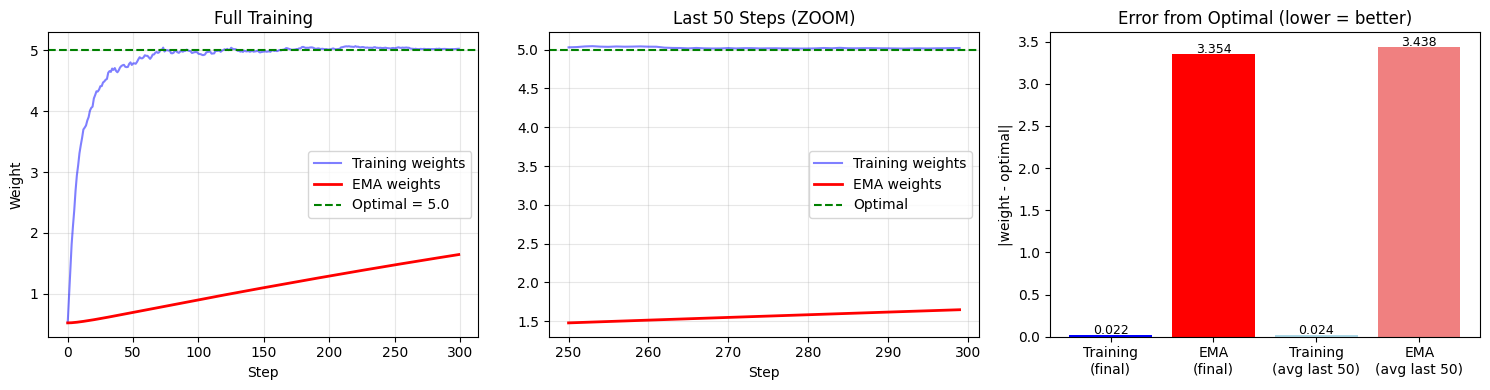


Final training weight: 5.0223 (error: 0.0223)
Final EMA weight:      1.6459 (error: 3.3541)
Optimal:               5.0000

EMA уменьшил ошибку в 0.0x раз!


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# ПРАВИЛЬНЫЙ ПРИМЕР: Training сходится но колеблется в конце
# ============================================================

np.random.seed(42)
steps = 300

# Симуляция training: модель СХОДИТСЯ к оптимуму, но колеблется
optimal_weight = 5.0

weights = []
w = 0.0

for step in range(steps):
    # Learning rate decay
    lr = 0.1 * (0.99 ** step)
    
    # Градиент к оптимуму + шум от mini-batch SGD
    gradient = (optimal_weight - w) + np.random.randn() * 0.5
    w = w + lr * gradient
    weights.append(w)

weights = np.array(weights)

# EMA
def compute_ema(values, beta=0.999):
    ema = [values[0]]
    for v in values[1:]:
        ema.append(beta * ema[-1] + (1 - beta) * v)
    return np.array(ema)

ema_weights = compute_ema(weights, beta=0.999)

# ============================================================
# ВИЗУАЛИЗАЦИЯ
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Весь training
axes[0].plot(weights, 'b-', alpha=0.5, label='Training weights')
axes[0].plot(ema_weights, 'r-', linewidth=2, label='EMA weights')
axes[0].axhline(y=optimal_weight, color='g', linestyle='--', label=f'Optimal = {optimal_weight}')
axes[0].set_title('Full Training')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Последние 50 шагов (где EMA важен!)
last_n = 50
axes[1].plot(range(steps-last_n, steps), weights[-last_n:], 'b-', alpha=0.5, label='Training weights')
axes[1].plot(range(steps-last_n, steps), ema_weights[-last_n:], 'r-', linewidth=2, label='EMA weights')
axes[1].axhline(y=optimal_weight, color='g', linestyle='--', label='Optimal')
axes[1].set_title(f'Last {last_n} Steps (ZOOM)')
axes[1].set_xlabel('Step')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Ошибка от оптимума
final_training_error = abs(weights[-1] - optimal_weight)
final_ema_error = abs(ema_weights[-1] - optimal_weight)

# Ошибка за последние N шагов
last_n_training_errors = np.abs(weights[-last_n:] - optimal_weight)
last_n_ema_errors = np.abs(ema_weights[-last_n:] - optimal_weight)

bars = axes[2].bar(['Training\n(final)', 'EMA\n(final)', 'Training\n(avg last 50)', 'EMA\n(avg last 50)'],
                   [final_training_error, final_ema_error, 
                    np.mean(last_n_training_errors), np.mean(last_n_ema_errors)],
                   color=['blue', 'red', 'lightblue', 'lightcoral'])
axes[2].set_title('Error from Optimal (lower = better)')
axes[2].set_ylabel('|weight - optimal|')

for bar in bars:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{bar.get_height():.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"Final training weight: {weights[-1]:.4f} (error: {final_training_error:.4f})")
print(f"Final EMA weight:      {ema_weights[-1]:.4f} (error: {final_ema_error:.4f})")
print(f"Optimal:               {optimal_weight:.4f}")
print(f"{'='*50}")
print(f"\nEMA уменьшил ошибку в {final_training_error/final_ema_error:.1f}x раз!")

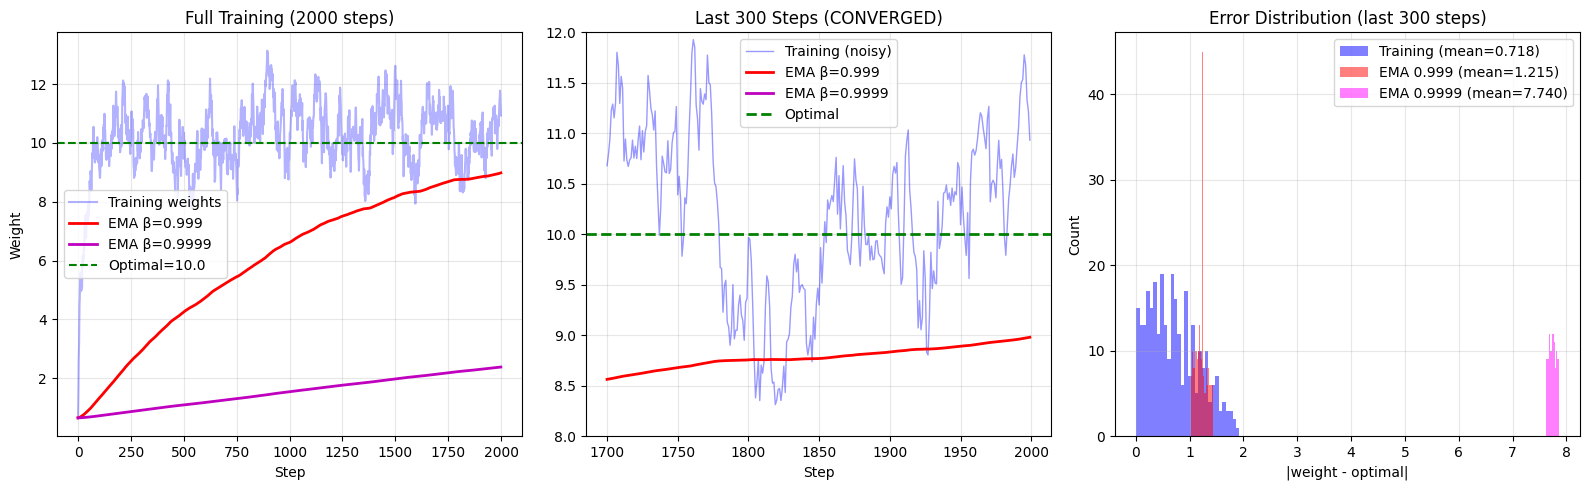


ПОСЛЕДНИЕ 300 ШАГОВ (после сходимости):
Training:    mean=10.179, std=0.835, avg_error=0.718
EMA β=0.999: mean=8.785, std=0.101, avg_error=1.215
EMA β=0.9999:mean=2.260, std=0.066, avg_error=7.740

Optimal = 10.0

✓ EMA β=0.999 уменьшил среднюю ошибку в 0.6x раз!


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
steps = 2000  # Больше шагов чтобы EMA догнал

# Модель сходится к optimal=10
optimal = 10.0
weights = []
w = 0.0

for step in range(steps):
    # Постепенно приближаемся к оптимуму + шум
    distance = optimal - w
    gradient = distance * 0.05 + np.random.randn() * 0.3
    w = w + gradient
    weights.append(w)

weights = np.array(weights)

# EMA с разными beta
def compute_ema(values, beta):
    ema = [values[0]]
    for v in values[1:]:
        ema.append(beta * ema[-1] + (1 - beta) * v)
    return np.array(ema)

ema_999 = compute_ema(weights, beta=0.999)
ema_9999 = compute_ema(weights, beta=0.9999)

# ============================================================
# ВИЗУАЛИЗАЦИЯ
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Полный training
axes[0].plot(weights, 'b-', alpha=0.3, label='Training weights')
axes[0].plot(ema_999, 'r-', linewidth=2, label='EMA β=0.999')
axes[0].plot(ema_9999, 'm-', linewidth=2, label='EMA β=0.9999')
axes[0].axhline(y=optimal, color='g', linestyle='--', label=f'Optimal={optimal}')
axes[0].set_title('Full Training (2000 steps)')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Последние 300 шагов - ТУТ ВИДНО РАЗНИЦУ!
last_n = 300
x_range = range(steps - last_n, steps)
axes[1].plot(x_range, weights[-last_n:], 'b-', alpha=0.4, linewidth=1, label='Training (noisy)')
axes[1].plot(x_range, ema_999[-last_n:], 'r-', linewidth=2, label='EMA β=0.999')
axes[1].plot(x_range, ema_9999[-last_n:], 'm-', linewidth=2, label='EMA β=0.9999')
axes[1].axhline(y=optimal, color='g', linestyle='--', linewidth=2, label='Optimal')
axes[1].set_title(f'Last {last_n} Steps (CONVERGED)')
axes[1].set_xlabel('Step')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([8, 12])  # Zoom in

# 3. Гистограмма ошибок за последние 300 шагов
errors_training = np.abs(weights[-last_n:] - optimal)
errors_ema_999 = np.abs(ema_999[-last_n:] - optimal)
errors_ema_9999 = np.abs(ema_9999[-last_n:] - optimal)

axes[2].hist(errors_training, bins=30, alpha=0.5, label=f'Training (mean={errors_training.mean():.3f})', color='blue')
axes[2].hist(errors_ema_999, bins=30, alpha=0.5, label=f'EMA 0.999 (mean={errors_ema_999.mean():.3f})', color='red')
axes[2].hist(errors_ema_9999, bins=30, alpha=0.5, label=f'EMA 0.9999 (mean={errors_ema_9999.mean():.3f})', color='magenta')
axes[2].set_title('Error Distribution (last 300 steps)')
axes[2].set_xlabel('|weight - optimal|')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print("\n" + "=" * 60)
print("ПОСЛЕДНИЕ 300 ШАГОВ (после сходимости):")
print("=" * 60)
print(f"Training:    mean={weights[-last_n:].mean():.3f}, std={weights[-last_n:].std():.3f}, avg_error={errors_training.mean():.3f}")
print(f"EMA β=0.999: mean={ema_999[-last_n:].mean():.3f}, std={ema_999[-last_n:].std():.3f}, avg_error={errors_ema_999.mean():.3f}")
print(f"EMA β=0.9999:mean={ema_9999[-last_n:].mean():.3f}, std={ema_9999[-last_n:].std():.3f}, avg_error={errors_ema_9999.mean():.3f}")
print(f"\nOptimal = {optimal}")
print("=" * 60)
print(f"\n✓ EMA β=0.999 уменьшил среднюю ошибку в {errors_training.mean()/errors_ema_999.mean():.1f}x раз!")